In [1]:
!pip install --upgrade tensorflow
!pip install tensorflow_decision_forests


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 30.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

In [2]:

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import xgboost as xgb


In [4]:

# Import data
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")


In [5]:

# Features
features = train_data.drop(['Id', 'SalePrice'], axis=1)

# Define The Target variable
target = train_data['SalePrice']

train_features, val_features, train_target, val_target = train_test_split(features, target, test_size=0.2, random_state=100)


In [6]:

# Preprocess categorical columns with one-hot encoding
categorical_columns = [
    'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
    'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
    'SaleCondition'
]

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')


In [7]:

# Fit the encoder using the categorical features from the training dataset
encoder.fit(train_features[categorical_columns])

# Apply the encoder to the train and validation datasets
train_features_encoded = train_features.join(pd.DataFrame(encoder.transform(train_features[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns), index=train_features.index))
val_features_encoded = val_features.join(pd.DataFrame(encoder.transform(val_features[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns), index=val_features.index))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:

# Remove original categorical features
train_features_encoded = train_features_encoded.drop(columns=categorical_columns)
val_features_encoded = val_features_encoded.drop(columns=categorical_columns)

# Apply mean imputation
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data
imputer.fit(train_features_encoded)


SimpleImputer()

In [9]:

# Transform both the training and validation data
train_features_encoded_imputed = imputer.transform(train_features_encoded)
val_features_encoded_imputed = imputer.transform(val_features_encoded)

# Train the RandomForest Model to identify the features with highest importance.
model = RandomForestRegressor()
model.fit(train_features_encoded_imputed, train_target)


RandomForestRegressor()

In [10]:

# Get feature importances
importances = model.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({"Feature": train_features_encoded.columns, "Importance": importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values("Importance", ascending=False)


         Feature  Importance
3    OverallQual    0.561596
15     GrLivArea    0.100940
11   TotalBsmtSF    0.039790
13      2ndFlrSF    0.039501
26    GarageArea    0.023761
8     BsmtFinSF1    0.023415
12      1stFlrSF    0.022913
182  BsmtQual_Ex    0.014779
5      YearBuilt    0.014215
2        LotArea    0.011893


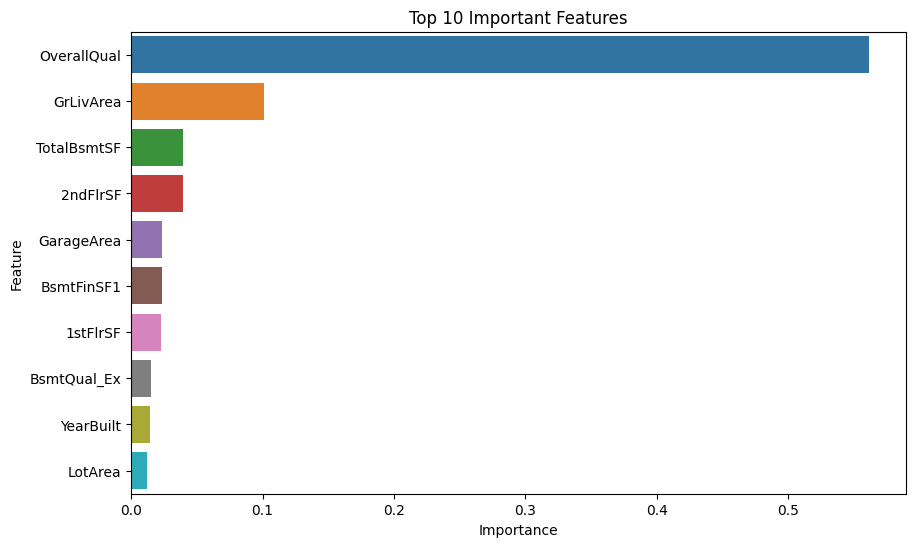

In [11]:

# Print top 10 features
print(feature_importances.head(10))

# Plot the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [12]:
# Convert the encoded features and target to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_features_encoded.values, train_target.values))
val_dataset = tf.data.Dataset.from_tensor_slices((val_features_encoded.values, val_target.values))


In [13]:

# Add batch operation to the datasets
batch_size = 100
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)


In [14]:

# Define the model
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

# Train the model
model.fit(train_dataset, validation_data=val_dataset)

# Print the shapes of input data and target values in val_dataset
for x, y in val_dataset.take(5):
    print("Input shape:", x.shape)
    print("Target shape:", y.shape)


Use /tmp/tmpqwi0mvkc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:15.881708. Found 1168 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(292, shape=(), dtype=int32)
Validation dataset read in 0:00:05.620779. Found 292 examples.
Training model...
Model trained in 0:00:23.157563
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Input shape: (100, 301)
Target shape: (100,)
Input shape: (100, 301)
Target shape: (100,)
Input shape: (92, 301)
Target shape: (92,)


In [15]:

# Make predictions
predictions = model.predict(val_dataset)


3/3 [==============================] - 3s 23ms/step


In [16]:

# Get the actual target values from the validation dataset
actual_values = list(val_target.values)


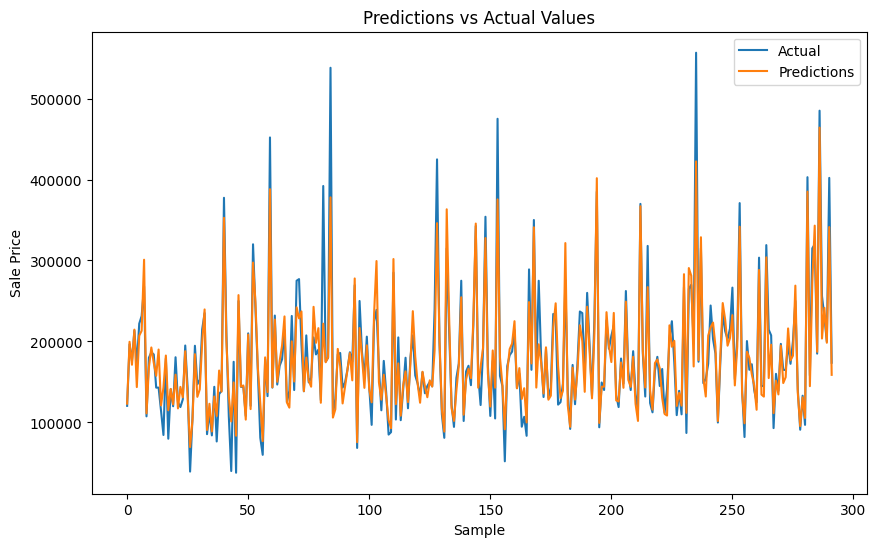

In [17]:

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predictions')
plt.xlabel('Sample')
plt.ylabel('Sale Price')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()


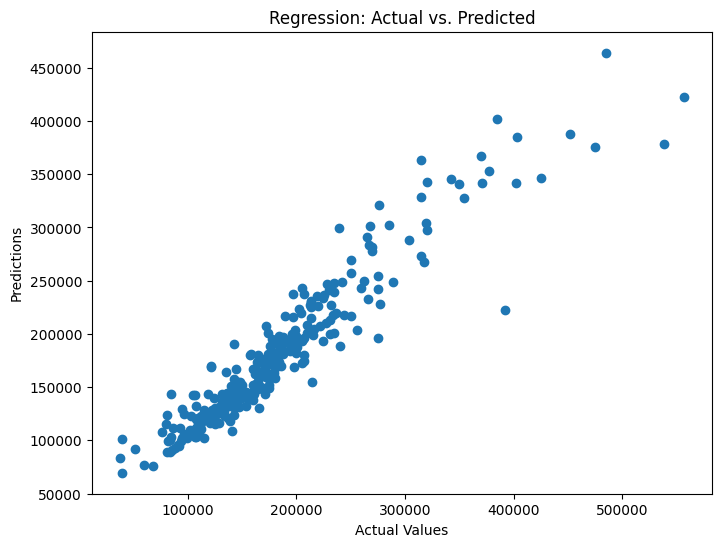

In [18]:

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Regression: Actual vs. Predicted')
plt.show()


In [19]:

# Regression evaluation metrics
mse = mean_squared_error(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)


Mean Squared Error (MSE): 722083535.6865124
Mean Absolute Error (MAE): 17063.372939854453
R-squared (R2) Score: 0.8876849575352795


In [38]:

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(train_features_encoded, label=train_target)
dval = xgb.DMatrix(val_features_encoded, label=val_target)

# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 3
}

# Train the XGBoost model
model = xgb.train(params, dtrain)

# Make predictions on the validation set
predictions = model.predict(dval)

# Evaluate the model
mse = mean_squared_error(val_target, predictions)
mae = mean_absolute_error(val_target, predictions)
r2 = r2_score(val_target, predictions)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 6656655120.28332
Mean Absolute Error (MAE): 67277.62219071062
R-squared (R2) Score: -0.03539613570721856


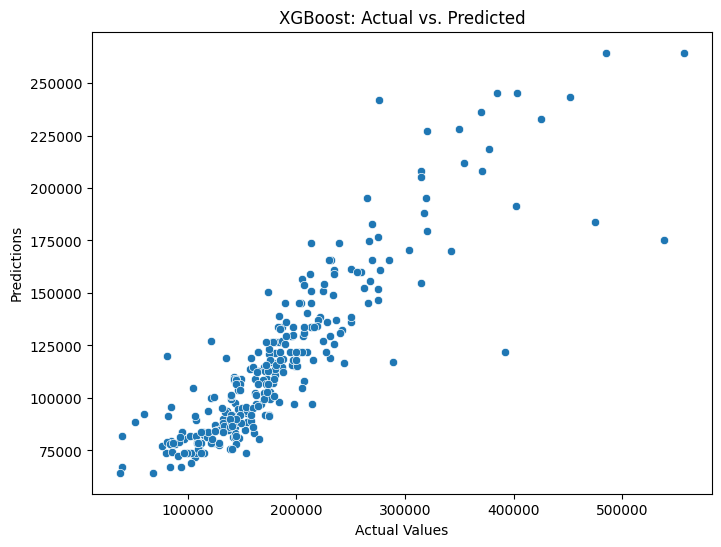

In [39]:
# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=val_target, y=predictions.flatten())  # flatten the predictions to a 1D array
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('XGBoost: Actual vs. Predicted')
plt.show()




          Feature  Importance
170  ExterQual_TA    0.205617
24     GarageCars    0.167884
14      GrLivArea    0.160604
10    TotalBsmtSF    0.059393
25     GarageArea    0.041994
11       1stFlrSF    0.038869
12       2ndFlrSF    0.035725
7      BsmtFinSF1    0.035475
4       YearBuilt    0.034599
181   BsmtQual_Ex    0.026072


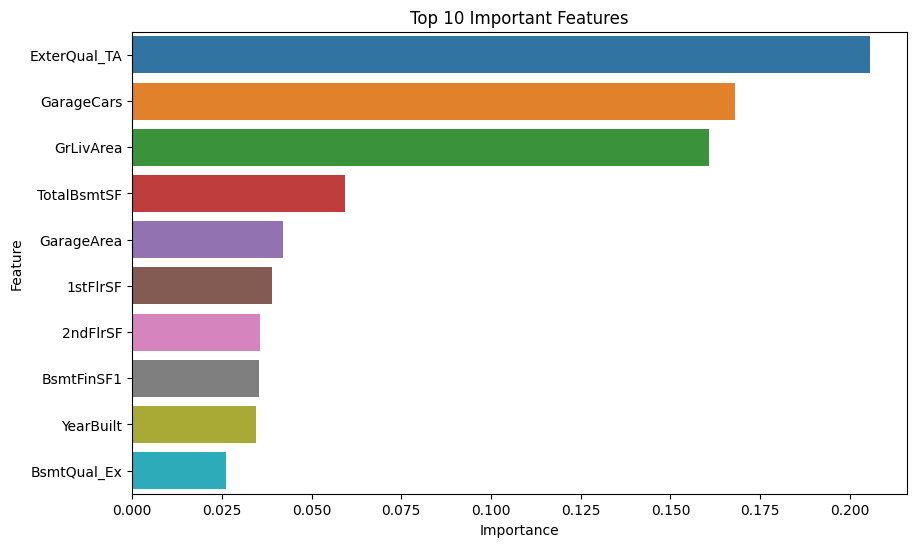

In [27]:
from sklearn.impute import SimpleImputer

# Initialize the imputer
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data
imputer.fit(train_features_encoded)

# Transform the training and validation data
train_features_encoded_imputed = imputer.transform(train_features_encoded)
val_features_encoded_imputed = imputer.transform(val_features_encoded)

# Convert back to DataFrame
train_features_encoded_imputed = pd.DataFrame(train_features_encoded_imputed, columns=train_features_encoded.columns)
val_features_encoded_imputed = pd.DataFrame(val_features_encoded_imputed, columns=val_features_encoded.columns)

# Now you can fit the model
model = RandomForestRegressor()
model.fit(train_features_encoded_imputed, train_target)

# Get feature importances
importances = model.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({"Feature": train_features_encoded_imputed.columns, "Importance": importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values("Importance", ascending=False)

#print top 10 features
print(feature_importances.head(10))

# Plot the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



10/10 [==============================] - 0s 2ms/step


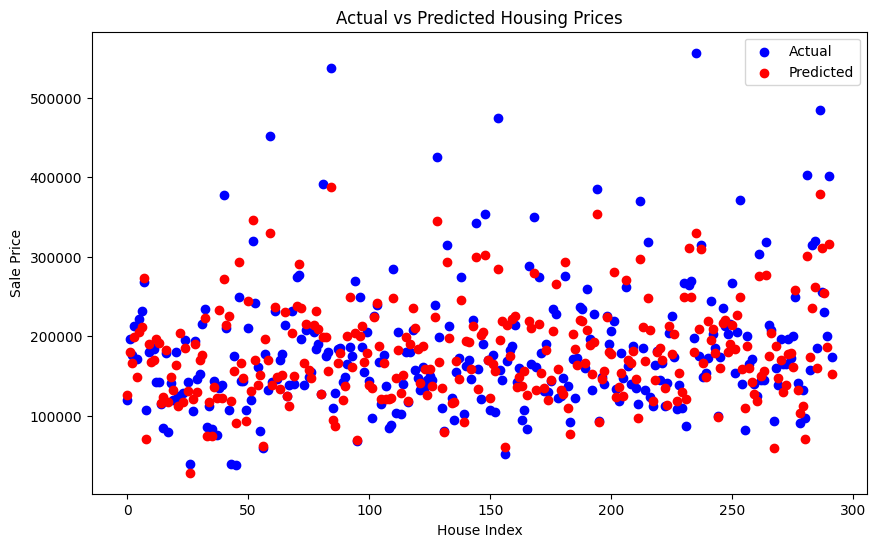

Mean Squared Error (MSE): 1696397433.4777012
Mean Absolute Error (MAE): 28305.44269718536
R-squared (R2) Score: 0.736137246784133


In [36]:
# Taking away the "overalQual"
# Make predictions for validation set
val_predictions = model.predict(val_features_encoded_imputed)

plt.figure(figsize=(10, 6))

# Plot the actual target values
plt.scatter(range(len(val_target)), val_target, color='blue', label='Actual')

# Plot the predicted target values
plt.scatter(range(len(val_predictions)), val_predictions.flatten(), color='red', label='Predicted')

plt.title('Actual vs Predicted Housing Prices')
plt.xlabel('House Index')
plt.ylabel('Sale Price')
plt.legend()
plt.show()


# Evaluate the model
mse = mean_squared_error(val_target, val_predictions)
mae = mean_absolute_error(val_target, val_predictions)
r2 = r2_score(val_target, val_predictions)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)
